In [10]:
# Preamble: minimal imports + local include
using Random
using Statistics
using Printf
using Plots
using Logging

if !isdefined(Main, :System1D)
    include("../src/System1D.jl")
end
using .System1D: Hamiltonian, TrialWF, Walker, DMCParams, DMCSim, ImportanceGuiding, FixedNode, run_simulation!, plot_snapshot_1d_density


## System: Hydrogen Atom in 1D with Odd Parity Trial Wavefunction

**Potential**
$$ V(x) = -\frac{1}{|x|} $$

**Trial wavefunction (odd parity)**
$$ \psi_T(x) = x e^{-\alpha |x|} $$
This enforces a node at $x=0$ via the sign of $x$. The simulation uses fixed-node DMC with importance sampling.

This cell sets parameters, initializes walkers, and runs the simulation.


In [11]:
# System: 1D Coulomb-like potential
V(R) = -1 / abs(R[1])
H = Hamiltonian(1, 0.5, V)

# Trial wavefunction (odd parity): psi_T(x) = x * exp(-alpha*|x|)
alpha = 1.0
logpsi(R) = begin
    x = R[1]
    ax = abs(x)
    return ax == 0 ? -Inf : log(ax) - alpha * ax
end

gradlogpsi(R) = begin
    x = R[1]
    ax = abs(x)
    s = sign(x)
    return ax == 0 ? [0.0] : [(s / ax) - alpha * s]
end

lapllogpsi(R) = begin
    x = R[1]
    ax = abs(x)
    return ax == 0 ? -Inf : -1.0 / ax^2
end

signpsi(R; tol=1e-12) = abs(R[1]) < tol ? 0.0 : sign(R[1])

trial = TrialWF(logpsi, gradlogpsi, lapllogpsi, signpsi)
guiding = ImportanceGuiding(trial, H)

# Walkers and params
targetN = 1000
walkers = [Walker([randn()]) for _ in 1:targetN]

params = DMCParams(0.005, 200, 40, targetN, -0.5, 0.1, 10, 50)

# Run
rng_sim = MersenneTwister(42)
sim = DMCSim(H, params, walkers, rng_sim; guiding=guiding, nodepolicy=FixedNode())
run_simulation!(sim; snapshot_steps=[params.nsteps])

ET_history = sim.ET_history
population_history = sim.population_history
energy_mean_history = sim.energy_mean_history
energy_variance_history = sim.energy_variance_history

nothing


## Results

**The 1D hydrogen atom has an analytic solution with ground state**
$$ E_0 \approx -\frac{1}{2} \; \text{(a.u.)} $$

This cell reports the post-equilibration energy and plots the reference energy, population, mean local energy, and local-energy variance over time, plus the final walker density.


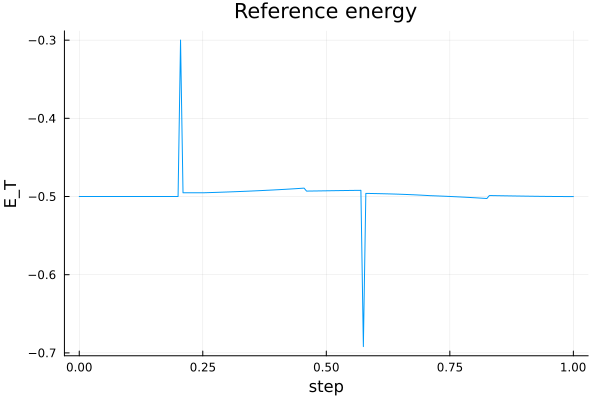

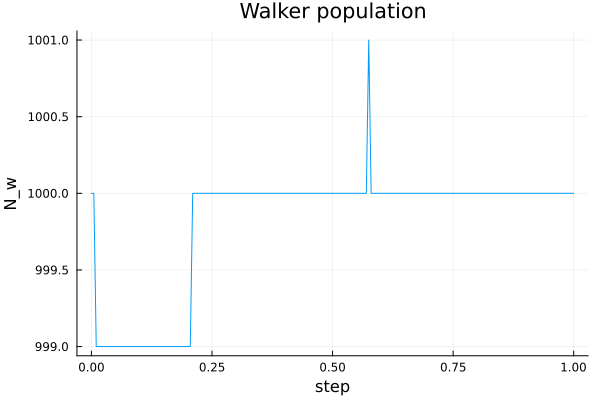

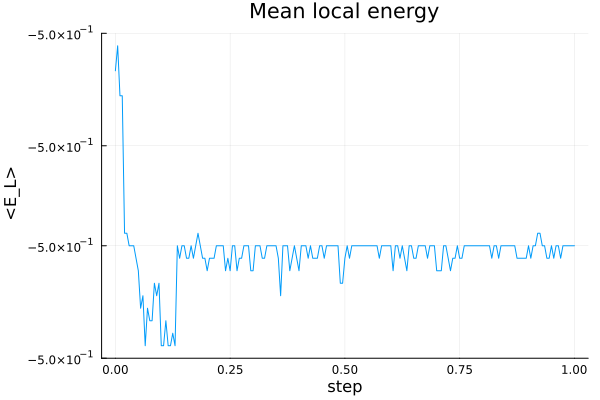

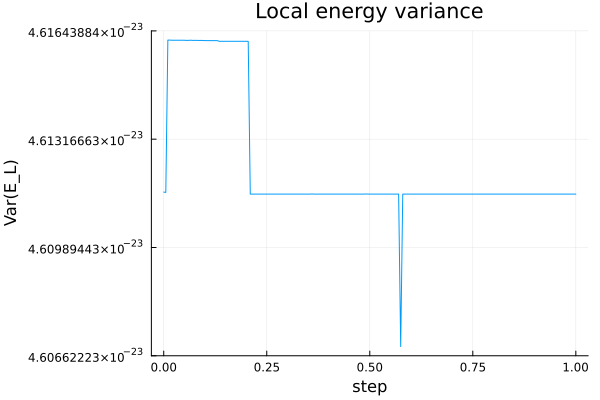

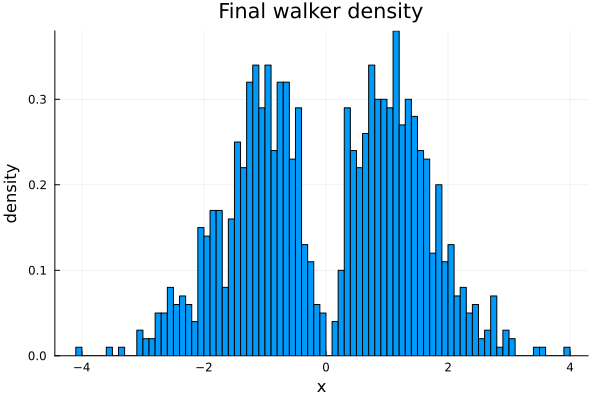

Hydrogen DMC energy (post-eq, nequil=40): E = -0.500000 +/- 0.000000
Final step: E = -0.500000, Var(E_L) = 0.000000


In [12]:
# Results and plots
t = (0:params.nsteps) .* params.dt

nequil = params.nequil
start_idx = min(nequil + 1, length(energy_mean_history))
postE = energy_mean_history[start_idx:end]

Ebar = mean(postE)
SEM = (length(postE) > 1) ? std(postE) / sqrt(length(postE)) : NaN

println(@sprintf("Hydrogen DMC energy (post-eq, nequil=%d): E = %.6f +/- %.6f", nequil, Ebar, SEM))
println(@sprintf("Final step: E = %.6f, Var(E_L) = %.6f", energy_mean_history[end], energy_variance_history[end]))


Logging.with_logger(Logging.NullLogger()) do
    redirect_stderr(devnull) do
        p1 = plot(t, ET_history, xlabel="step", ylabel="E_T", title="Reference energy", label=false)
        display(p1)
        
        p2 = plot(t, population_history, xlabel="step", ylabel="N_w", title="Walker population", label=false)
        display(p2)
        
        p3 = plot(t, energy_mean_history, xlabel="step", ylabel="<E_L>", title="Mean local energy", label=false)
        display(p3)
        
        p4 = plot(t, energy_variance_history, xlabel="step", ylabel="Var(E_L)", title="Local energy variance", label=false)
        display(p4)
        
        if !isempty(sim.walker_positions_history)
            snap = sim.walker_positions_history[end]
            p5 = plot_snapshot_1d_density(snap; nbins=120, title="Final walker density")
            display(p5)
        end
    end
end
